In [1]:
import itertools
import numpy as np
import pandas as pd
import scipy.stats as stats

from sklearn.preprocessing import LabelEncoder
from sklearn import feature_selection
from sklearn.preprocessing import PowerTransformer

import seaborn as sns
from matplotlib import pyplot
from statsmodels.graphics.gofplots import qqplot

sns.set()

In [2]:
df = pd.read_csv("raw.csv")
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,name
0,18.0,8,307.0,130.0,3504,12.0,70,usa,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,usa,buick skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,usa,plymouth satellite
3,16.0,8,304.0,150.0,3433,12.0,70,usa,amc rebel sst
4,17.0,8,302.0,140.0,3449,10.5,70,usa,ford torino


In [3]:
df.shape

(398, 9)

In [4]:
# let's list all the columns
columns = list(df.columns)
columns

['mpg',
 'cylinders',
 'displacement',
 'horsepower',
 'weight',
 'acceleration',
 'model_year',
 'origin',
 'name']

In [5]:
# we now describe the properties of this dataframe like column datatype etc.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    392 non-null    float64
 4   weight        398 non-null    int64  
 5   acceleration  398 non-null    float64
 6   model_year    398 non-null    int64  
 7   origin        398 non-null    object 
 8   name          398 non-null    object 
dtypes: float64(4), int64(3), object(2)
memory usage: 28.1+ KB


In [6]:
cats = list(df.select_dtypes(include=['object']).columns)
nums = list(df.select_dtypes(exclude=['object']).columns)
print(f'categorical variables:  {cats}')
print(f'numerical variables:  {nums}')

categorical variables:  ['origin', 'name']
numerical variables:  ['mpg', 'cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model_year']


In [7]:
# cylinders and model_year also seems to be categorical so lets update the lists
cats.extend(['cylinders', 'model_year'])
nums.remove('cylinders')
nums.remove('model_year')

print(f'categorical variables:  {cats}')
print(f'numerical variables:  {nums}')

categorical variables:  ['origin', 'name', 'cylinders', 'model_year']
numerical variables:  ['mpg', 'displacement', 'horsepower', 'weight', 'acceleration']


In [8]:
# check for `nans` in each column
df.isna().sum()

mpg             0
cylinders       0
displacement    0
horsepower      6
weight          0
acceleration    0
model_year      0
origin          0
name            0
dtype: int64

In [9]:
# nan rows proportion in data
6 / len(df)

0.01507537688442211

In [10]:
# for now remove all nan rows as they are just 1.5%
df = df[~df.isnull().any(axis=1)]
df.reset_index(inplace=True)
df.drop('index', inplace=True, axis=1)
df.shape

(392, 9)

In [11]:
# find total duplicate entries and drop them if any
print(f'total duplicate rows: {df.duplicated().sum()}')

# drop duplicate rows if any
df = df[~df.duplicated()]
df.shape

total duplicate rows: 0


(392, 9)

In [12]:
# remove extra spaces if any
for col in ['origin', 'name']:
    df[col] = df[col].apply(lambda x: ' '.join(x.split()))

In [13]:
df['mpg_level'] = df['mpg'].apply(lambda x: 'low' if x<17 else 'high' if x>29 else 'medium')
cats.append('mpg_level')
print(f'categorical variables:  {cats}')

categorical variables:  ['origin', 'name', 'cylinders', 'model_year', 'mpg_level']


In [14]:
# before we move ahead it's a good practice to group all variables together having same type.
df = pd.concat((df[cats], df[nums]), axis=1)
df.head()

,origin,name,cylinders,model_year,mpg_level,mpg,displacement,horsepower,weight,acceleration
0,usa,chevrolet chevelle malibu,8,70,medium,18.0,307.0,130.0,3504,12.0
1,usa,buick skylark 320,8,70,low,15.0,350.0,165.0,3693,11.5
2,usa,plymouth satellite,8,70,medium,18.0,318.0,150.0,3436,11.0
3,usa,amc rebel sst,8,70,low,16.0,304.0,150.0,3433,12.0
4,usa,ford torino,8,70,medium,17.0,302.0,140.0,3449,10.5


### Statistical Hypothesis Tests
The idea of Statistical Hypothesis Tests is very simple and straight forward. We first assumes something about the data like two samples has same mean etc. And then we find the likelihood of observing the given data assuming this assumption as true. If the likelihood is close to zero then we **reject the assumption** and if the likelihood has value greater than some threshold(set by us) then we **fail to reject the assumption**.

In statistics lingo the assumption is called **Hypothesis**, the likelihood we get is called **p-value**, the threshold we set is of two types either **level of significance** or **critical value** and the test we use is called **Statistical Hypothesis Tests**.

So if the likelihood we get is very close to zero then that mean **assuming this hypothesis to be true the likelihood of observing/occurring this data is very less** so that suggests there is something wrong with our assumption. So in the example to means of 2 samples, if the resulted p-value is very close to zero than we can say that **assuming the two samples having the same mean the data we have in hand is very less likely to be generated hence there is something wrong with our assumption and hence we reject it.**

    Note all this is probabilistic and we can do mistakes sometimes and there are known name for those mistakes namely False Positive and False Negative.

### Hypothesis

There are two type of hypothesis namely-<br><br>
**Null Hypothesis, $H_{0}$ -** A null hypothesis, proposes that no significant difference exists in a set of given observations.<br>
**Alternate Hypothesis, $H_{1}$ -** An alternate hypothesis, proposes that there is a significant difference exists in a set of given observations.

For the purpose of these tests in general,

&emsp;&emsp;&emsp;$H_{0}$: Variable A and Variable B are independent<br>
&emsp;&emsp;&emsp;$H_{1}$: Variable A and Variable B are not independent.

**Note:** $H_{0}$ and $H_{1}$ are complement of each other.


### p-value
It's the probability of data given the assumption in a statistical test.

$$\large Pr(data\ | \ assumption)$$

The **statistical significance** of any finding is done by intrerpreting the p-values. P-value tells us that whether are findings are due to same real change or they are just random fluctuations. 

* p-value ≤ $\alpha$: significant result, reject null hypothesis.
* p-value > $\alpha$: not significant result, fail to reject the null hypothesis.

A p-value can be calculated from a test statistic by retrieving the probability from the test statistics cumulative density function (CDF).

Some tests return a test statistic value from a specific data distribution that can be interpreted in the context of critical values. A **critical value** is a value from the distribution of the test statistic after which point the result is significant
and the null hypothesis can be rejected.
* Test Statistic < Critical Value: not significant result, fail to reject null hypothesis.
* Test Statistic ≥ Critical Value: significant result, reject null hypothesis.

**Note:** The most common value for significance level used throughout the data science and ML is 5% i.e., $\alpha=0.05$ and we will be using this same value throughout this notebook.

I recommend **Statistical Methods for ML by Jason Brownlee** if you want to go in-depth.

[refer this decision tree](https://qphs.fs.quoracdn.net/main-qimg-0138e6d464b3ff6320971528e4e72c04)

In [15]:
ALPHA = 0.05

## Tests for independence between two categorical variables

### Pearson's Chi-square test
The Chi-square statistic is a **non-parametric statistic** tool designed to analyze group differences when the dependent variable is measured at a nominal level(ordinal data can also be used). It is commonly used to compare observed data with data we would expect to obtain according to a specific hypothesis.

$$\large \chi ^{2} = \sum \frac{(O-E)^{2}}{E}$$

Where,<br>
&emsp;&emsp;O : Observed (the actual count of cases in each cell of the table)<br>
&emsp;&emsp;E : Expected value (calculated below)<br>
&emsp;&emsp;$\chi ^{2}$ : The cell Chi-square value

**Assumptions**<br>
&emsp;&emsp;&emsp;**1.** The test becomes invalid if any of the expected values are below 5<br>
&emsp;&emsp;&emsp;**2.** The p value calculated is not exact but approximate and converges to exact on increasing data(so not good for small sample size)<br>
&emsp;&emsp;&emsp;**3.** The number of observations must be 20+<br>

So, if the expected cell counts are small, it is better to use an exact test as the chi-squared test is no longer a good approximation in such cases. To overcome this we will be using fisher exact test.

### Fisher’s exact test
Fisher’s exact test is used to determine whether there is a significant association between two categorical variables in a contingency table. Fisher’s exact test is an alternative to Pearson’s chi-squared test for independence. While actually valid for all sample sizes, Fisher’s exact test is practically applied when sample sizes are small.
A general recommendation is to use Fisher’s exact test- instead of the chi-squared test - whenever more than 20 % of cells in a contingency table have expected frequencies < 5.

In [16]:
# Contingency Table (aka frequency table)
pd.crosstab(df.origin, df.model_year)

model_year,70,71,72,73,74,75,76,77,78,79,80,81,82
origin,,,,,,,,,,,,,
europe,5,4,5,7,6,6,8,4,6,4,8,3,2
japan,2,4,5,4,6,4,4,6,8,2,13,12,9
usa,22,19,18,29,14,20,22,18,22,23,6,13,19


&emsp;&emsp;&emsp;$H_{0}$: origin are model_year are independent. &emsp;&emsp;&emsp;&emsp;&emsp;&emsp; $\alpha=0.05$

In [17]:
observed_values = pd.crosstab(df.origin, df.mpg_level).values
observed_values

array([[ 22,   2,  44],
       [ 49,   0,  30],
       [ 24,  90, 131]])

In [18]:
# help(stats.chi2_contingency)
chi2, p, dof, expected_values = stats.chi2_contingency(observed_values)
chi2, p, dof, expected_values

(np.float64(123.76491109767298),
 np.float64(8.381476294026467e-26),
 4,
 array([[ 16.47959184,  15.95918367,  35.56122449],
        [ 19.14540816,  18.54081633,  41.31377551],
        [ 59.375     ,  57.5       , 128.125     ]]))

In [19]:
if p <= ALPHA:
    print(f'Rejected H0 under significance level {ALPHA} `origin` & `model_year` are dependent.')
else:
    print(f'Fail to reject H0 due to lack of evidence under significance level {ALPHA} `origin` & `model_year` are independent.')

Rejected H0 under significance level 0.05 `origin` & `model_year` are dependent.


In [20]:
nums

['mpg', 'displacement', 'horsepower', 'weight', 'acceleration']

### 1. Visual Normality Checks
We will visually check for normality using -
1. Histogram
2. Quantile-Quantile plot

C:\Users\DELL\AppData\Local\Temp\ipykernel_8704\1802822063.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.log2(df.mpg))
C:\Users\DELL\AppData\Local\Temp\ipykernel_8704\1802822063.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.log2(df.weight))


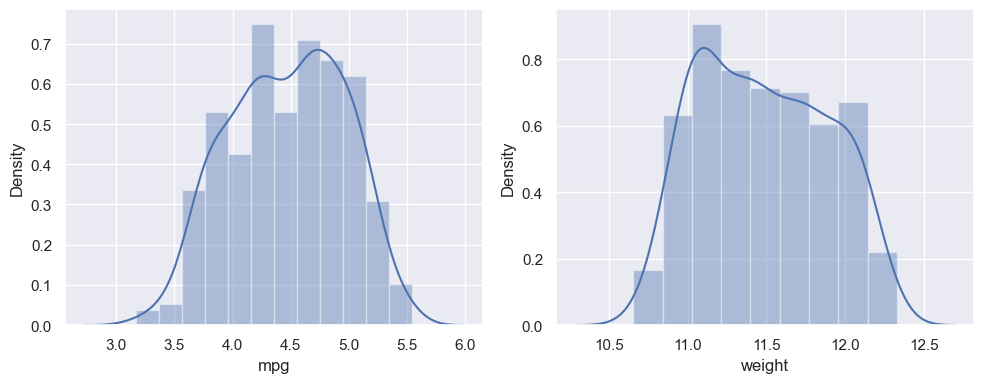

In [23]:
fig = pyplot.figure(1, (10, 4))

ax = pyplot.subplot(1,2,1)
sns.distplot(np.log2(df.mpg))
pyplot.tight_layout()

ax = pyplot.subplot(1,2,2)
sns.distplot(np.log2(df.weight))
pyplot.tight_layout()

pyplot.show()

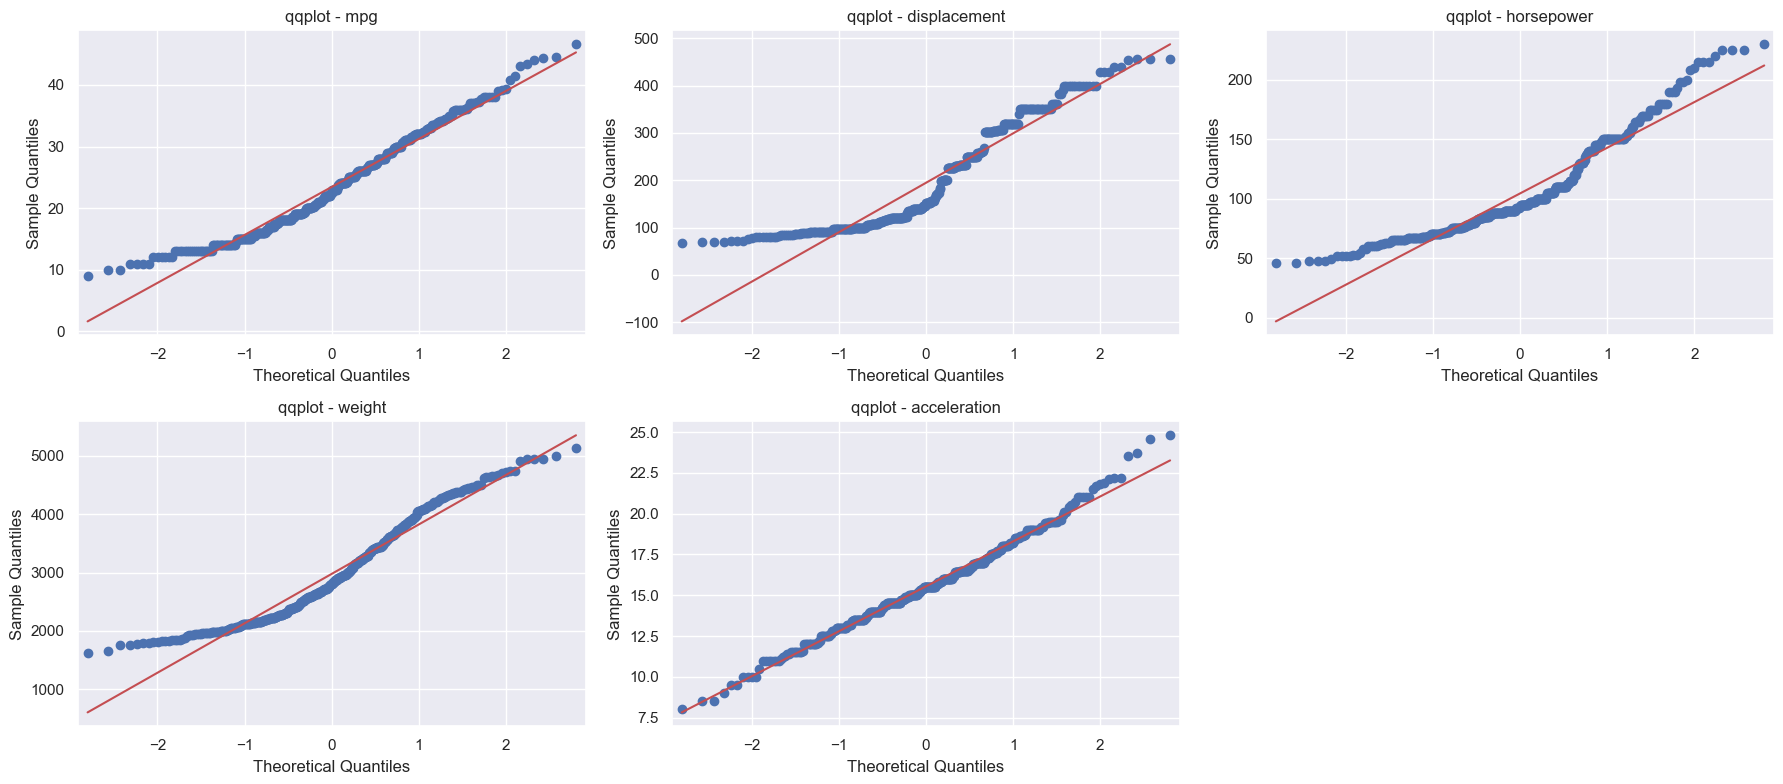

In [24]:
# quantile-quantile plots on original data
fig = pyplot.figure(1, (18,8))

for i,num in enumerate(nums):
    ax = pyplot.subplot(2,3,i+1)
    qqplot(df[num], line= 's', ax=ax)
    ax.set_title(f'qqplot - {num}')
    pyplot.tight_layout()

### Statistical Normality Tests

We will do hypothesis testing for the normality of numerical attributes using the `shapiro wilk test`.<br>

&emsp;&emsp;&emsp;$H_{0}$: Data is drawn from normal distribution. &emsp;&emsp;&emsp;&emsp;&emsp;&emsp; $\alpha=0.05$

In [25]:
# let's contruct a function
def shapiro_wilk_test(df: pd.DataFrame, cols: list, alpha=0.05):
    # test the null hypothesis for columns given in `cols` of the dataframe `df` under significance level `alpha`.
    for col in cols:
        _,p = stats.shapiro(df[col])
        if p <= alpha:
            print(f'''\nRejected H0 under significance level {alpha}\n{col} doesn't seems to be normally distributed''')
        else:
            print(f'''\nFail to reject H0 due to lack of evidence under significance level {alpha}\n{col} seem to be normally distributed''')

In [26]:
shapiro_wilk_test(df, nums)


Rejected H0 under significance level 0.05
mpg doesn't seems to be normally distributed

Rejected H0 under significance level 0.05
displacement doesn't seems to be normally distributed

Rejected H0 under significance level 0.05
horsepower doesn't seems to be normally distributed

Rejected H0 under significance level 0.05
weight doesn't seems to be normally distributed

Rejected H0 under significance level 0.05
acceleration doesn't seems to be normally distributed


In [27]:
df_tfnum = pd.DataFrame(PowerTransformer().fit_transform(df[nums]), columns=nums)
df_tfnum.head()

,mpg,displacement,horsepower,weight,acceleration
0,-0.635451,1.119336,0.854984,0.744740,-1.317572
1,-1.142697,1.324530,1.443754,0.919500,-1.522941
2,-0.635451,1.175211,1.216062,0.678812,-1.732292
3,-0.965340,1.103648,1.216062,0.675864,-1.317572
4,-0.796543,1.093078,1.044925,0.691548,-1.945873


C:\Users\DELL\AppData\Local\Temp\ipykernel_8704\1920791765.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_tfnum[num])
C:\Users\DELL\AppData\Local\Temp\ipykernel_8704\1920791765.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_tfnum[num])
C:\Users\DELL\AppData\Local\Temp\ipykernel_8

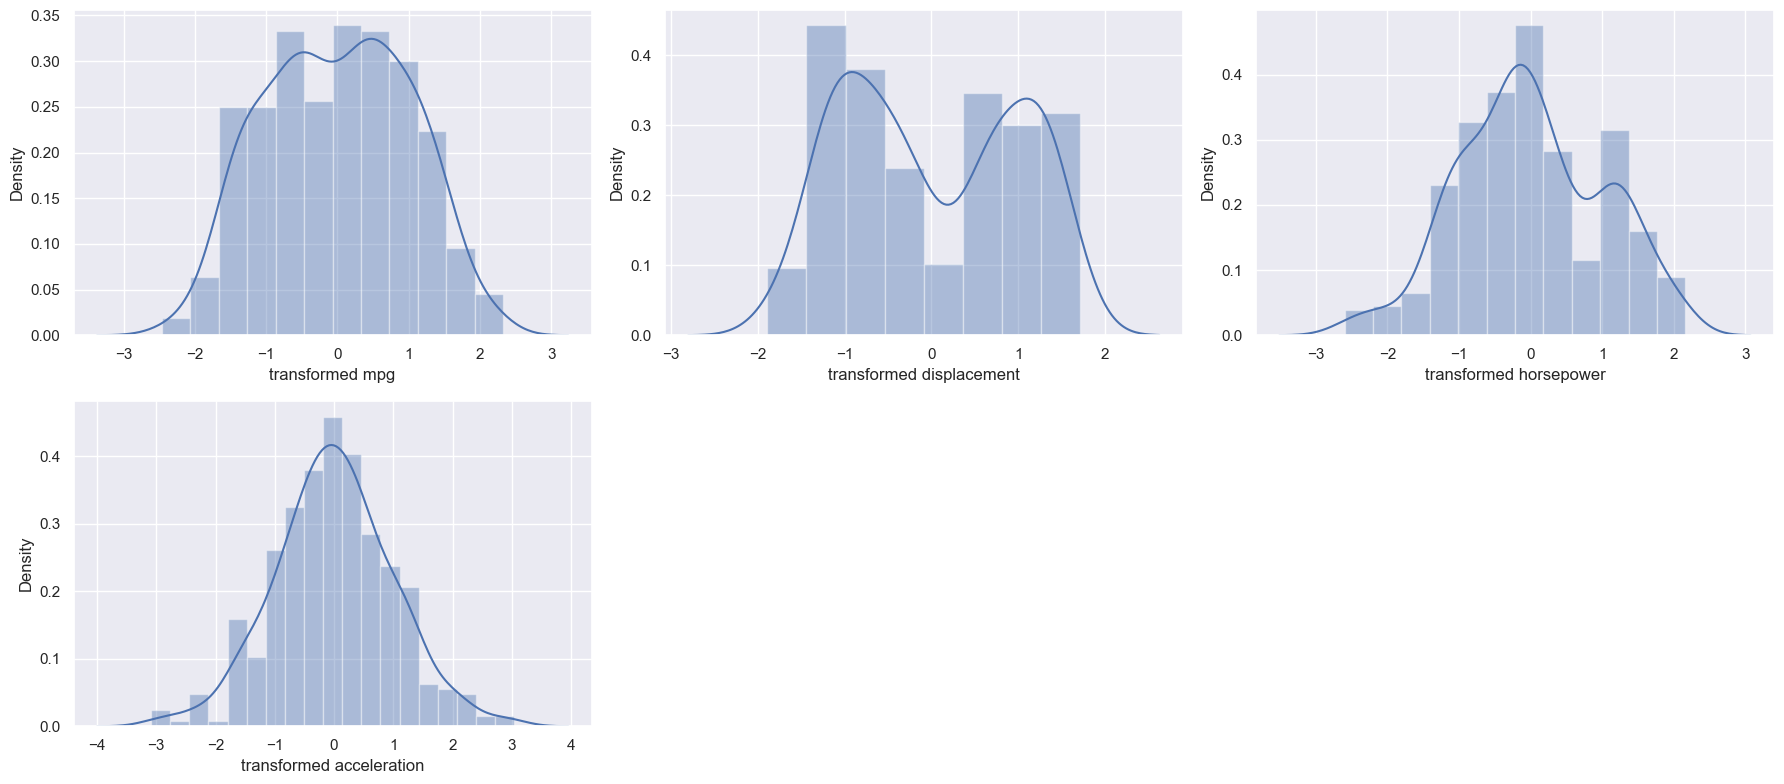

In [28]:
fig = pyplot.figure(1, (18,8))

for i,num in enumerate(['mpg', 'displacement', 'horsepower', 'acceleration']):
    ax = pyplot.subplot(2,3,i+1)
    sns.distplot(df_tfnum[num])
    ax.set_xlabel(f'transformed {num}')
    pyplot.tight_layout()

In [29]:
shapiro_wilk_test(df_tfnum, ['mpg', 'displacement', 'horsepower', 'acceleration'])


Rejected H0 under significance level 0.05
mpg doesn't seems to be normally distributed

Rejected H0 under significance level 0.05
displacement doesn't seems to be normally distributed

Rejected H0 under significance level 0.05
horsepower doesn't seems to be normally distributed

Fail to reject H0 due to lack of evidence under significance level 0.05
acceleration seem to be normally distributed


## Tests for correlation between two continous variables

### Covariance

$$\large Cov(x,y) = \frac{\sum (x_{_i}-\bar{x})(y_{_i}-\bar{y})}{n-1}$$

The use of the mean in the calculation suggests the need for each data sample to have a Gaussian or Gaussian-like distribution hence its **parametric statistic**. Also it's hard to interpret because it can take any value.

## Linear Association (Pearson's Correlation)

$$\large Corr_{_p}(x,y) = \frac{Cov(x,y)}{\sigma _{x}\sigma _{y}}$$

The Pearson correlation coefficient is just a **normalized covariance** between the two variables to give an interpretable score such that $Corr_{p}(x,y)\in [-1,1]$. It can be used to summarize the strength of the linear relationship between two data samples. The use of mean and standard deviation in the calculation suggests the need for the two data samples to have a Gaussian or Gaussian-like distribution hence it's a **parametric statistic**.


In [31]:
numeric_df = df.select_dtypes(include=['number'])
numeric_df.head()

,cylinders,model_year,mpg,displacement,horsepower,weight,acceleration
0,8,70,18.0,307.0,130.0,3504,12.0
1,8,70,15.0,350.0,165.0,3693,11.5
2,8,70,18.0,318.0,150.0,3436,11.0
3,8,70,16.0,304.0,150.0,3433,12.0
4,8,70,17.0,302.0,140.0,3449,10.5


<Axes: >

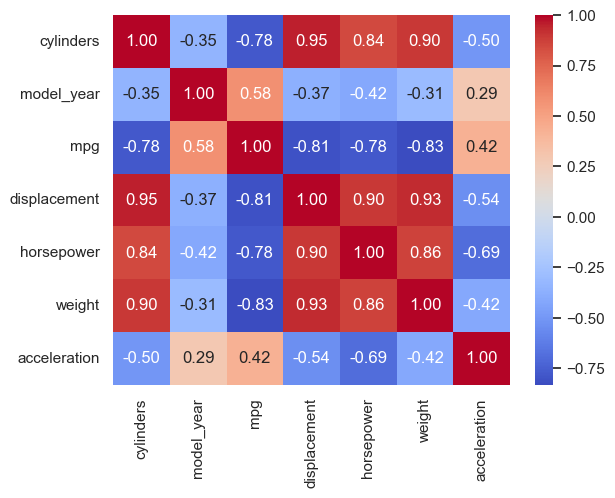

In [34]:
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")

### Parametric Statistical Significance Tests
1. **Student’s t-test** - It tests whether the two independent normal distributed samples has the same mean or not.
2. **Analysis of Variance Test (ANOVA)** - It tests whether the two or more independent normal distributed samples has the same mean or not.

ANOVA is same as t-test but for more than 2 variables. So either we can apply t-test pair-wise of apply ANOVA once. Also ANOVA only tells whether all samples are same or not, it doesn't quantify which samples differ or by how much.

In [35]:
shapiro_wilk_test(df[df.origin=='japan'], ['acceleration'])


Fail to reject H0 due to lack of evidence under significance level 0.05
acceleration seem to be normally distributed


In [36]:
shapiro_wilk_test(df[df.origin=='usa'], ['acceleration'])


Fail to reject H0 due to lack of evidence under significance level 0.05
acceleration seem to be normally distributed


&emsp;&emsp;&emsp;$H_{0}$: `acceleration of japan` and `acceleration of usa` has same sample mean. &emsp;&emsp;&emsp;&emsp;&emsp;&emsp; $\alpha=0.05$

In [37]:
# because the variance is not same for the two distributions hence equal_var=False
_, p = stats.ttest_ind(df[df.origin=='japan'].acceleration, df[df.origin=='usa'].acceleration, equal_var=False)

if p <= ALPHA:
    print(f'Rejected H0 under {ALPHA*100}% significance, Different distributions.')
else:
    print(f'Fail to Reject H0 under {ALPHA*100}% significance, Same distributions.')

Rejected H0 under 5.0% significance, Different distributions.


In [38]:
_, p = stats.f_oneway(df[df.origin=='japan'].acceleration, df[df.origin=='usa'].acceleration, df[df.origin=='europe'].acceleration)

if p <= ALPHA:
    print(f'Rejected H0 under {ALPHA*100}% significance, Different distributions.')
else:
    print(f'Fail to Reject H0 under {ALPHA*100}% significance, Same distributions.')

Rejected H0 under 5.0% significance, Different distributions.


&emsp;&emsp;&emsp;$H_{0}$: Sample distributions are equal for horsepower across region. &emsp;&emsp;&emsp;&emsp;&emsp;&emsp; $\alpha=0.05$

In [43]:
_, p = stats.kruskal(df[df.origin=='japan'].horsepower, df[df.origin=='usa'].horsepower, df[df.origin=='europe'].horsepower)

if p <= ALPHA:
    print(f'Rejected H0 under {ALPHA*100}% significance, Different distributions.')
else:
    print(f'Fail to Reject H0 under {ALPHA*100}% significance, Same distributions.')

Rejected H0 under 5.0% significance, Different distributions.


### Relation between Categorical and Continous attributes

In [46]:
# help(feature_selection.f_classif)
result_f = feature_selection.f_classif(df.loc[:, 'mpg': 'acceleration'], df.cylinders)
anova_test_cat = pd.DataFrame({
    'cat-attr': 'cylinders',
    'cont-attr': df.loc[:, 'mpg': 'acceleration'].columns,
    'f': result_f[0],
    'p': result_f[1],
    'alpha': ALPHA
})
anova_test_cat['H0'] = anova_test_cat.p.apply(lambda x: 'rejected' if x <= ALPHA else 'fail to reject')
anova_test_cat['relation'] = anova_test_cat.H0.apply(lambda x: 'dependent' if x=='rejected' else 'independent')
anova_test_cat

,cat-attr,cont-attr,f,p,alpha,H0,relation
0,cylinders,mpg,172.954629,8.785541e-85,0.05,rejected,dependent
1,cylinders,displacement,933.260216,3.054493e-197,0.05,rejected,dependent
2,cylinders,horsepower,297.855648,1.079822e-116,0.05,rejected,dependent
3,cylinders,weight,414.851887,1.751845e-138,0.05,rejected,dependent
4,cylinders,acceleration,48.677596,3.709542e-33,0.05,rejected,dependent


In [48]:
result_f = feature_selection.f_classif(df_cat_label[['origin', 'cylinders', 'model_year']], df.mpg)
anova_test_cat = pd.DataFrame({
    'cont-attr': 'mpg',
    'cat-attr': ['origin', 'cylinders', 'model_year'],
    'f': result_f[0],
    'p': result_f[1],
    'alpha': ALPHA
})
anova_test_cat['H0'] = anova_test_cat.p.apply(lambda x: 'rejected' if x <= ALPHA else 'fail to reject')
anova_test_cat['relation'] = anova_test_cat.H0.apply(lambda x: 'dependent' if x=='rejected' else 'independent')
anova_test_cat

NameError: name 'df_cat_label' is not defined